In [35]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, struct
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType
from pyspark.ml.evaluation import RegressionEvaluator
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from typing import Tuple, Optional
import os
from sklearn.model_selection import train_test_split

In [43]:
class EfficientRandomKUserRecommender:
    def __init__(self, k: int = 5):
        """
        Initialize the recommender with configuration parameters
        """
        self.k = k
        self.train_data = None
        self.user_similarities = None
        if not isinstance(self.k, int) or self.k <= 0:
            raise ValueError("k must be a positive integer")

    def prepare_data(self, ratings_df: pd.DataFrame, spark_session=None) -> Optional[pd.DataFrame]:
        """
        Prepare and validate the input data
        Args:
            ratings_df: Input ratings DataFrame
            spark_session: Optional SparkSession instance
        Returns:
            Spark DataFrame with prepared data
        """
        try:

            if ratings_df.empty:
                raise ValueError("Input DataFrame is empty")

            # Add debug print to check input data
            print(f"Input DataFrame shape: {ratings_df.shape}")
            print(f"Sample of input data:\n{ratings_df.head()}")

            # Convert matrix to long format directly
            ratings_long = (ratings_df
                .reset_index(names='user_id')
                .melt(
                    id_vars='user_id',
                    var_name='joke_id',
                    value_name='rating'
                )
            )

            # Add debug print after melting
            print(f"Long format shape: {ratings_long.shape}")
            print(f"Sample after melting:\n{ratings_long.head()}")

            # Remove NaN and invalid ratings
            ratings_long = ratings_long.dropna()
            ratings_long = ratings_long[
                (ratings_long['rating'] >= 0) &  # Adjust range based on your actual data
                (ratings_long['rating'] <= 5)
            ]

            # Add debug print after filtering
            print(f"Shape after filtering: {ratings_long.shape}")
            print(f"Rating range: {ratings_long['rating'].min()} to {ratings_long['rating'].max()}")

            if ratings_long.empty:
                raise ValueError("No valid ratings after preprocessing")

            # Convert to Spark DataFrame with explicit schema
            spark_schema = StructType([
                StructField("user_id", IntegerType(), False),
                StructField("joke_id", StringType(), False),
                StructField("rating", FloatType(), False)
            ])

            # Get Spark session consistently
            spark_session = spark_session or SparkSession.builder.getOrCreate()

            spark_df = spark_session.createDataFrame(
                ratings_long,
                schema=spark_schema
            )

            return spark_df.cache()

        except Exception as e:
            print(f"Error in data preparation: {str(e)}")
            return None

    def fit(self, ratings_df: pd.DataFrame) -> bool:
        """
        Fit the model with enhanced distribution-aware similarity metrics
        """
        try:
            print("Preparing training data...")
            self.train_data = self.prepare_data(ratings_df)
            if self.train_data is None:
                return False

            print("Calculating user statistics...")
            # Enhanced user statistics with distribution metrics
            user_stats = (self.train_data
                .groupBy("user_id")
                .agg(
                    F.count("rating").alias("rating_count"),
                    F.avg("rating").alias("avg_rating"),
                    F.stddev("rating").alias("rating_std"),
                    F.max("rating").alias("max_rating"),
                    F.min("rating").alias("min_rating"),
                    F.expr("percentile_approx(rating, array(0.25, 0.5, 0.75))").alias("percentiles")
                )
                .cache()
            )

            print("Computing user similarities...")
            window_spec = Window.partitionBy("base_user_id").orderBy(F.desc("similarity"))

            # Create other_stats with enhanced metrics
            other_stats = user_stats.select(
                F.col("user_id").alias("other_user_id"),
                F.col("rating_count").alias("other_count"),
                F.col("avg_rating").alias("other_avg"),
                F.col("rating_std").alias("other_std"),
                F.col("max_rating").alias("other_max"),
                F.col("min_rating").alias("other_min"),
                F.col("percentiles").alias("other_percentiles")
            )

            # Compute similarities with distribution-aware metrics
            self.user_similarities = (
                user_stats.select(
                    F.col("user_id").alias("base_user_id"),
                    F.col("*")
                )
                .crossJoin(other_stats)
                .where(F.col("base_user_id") != F.col("other_user_id"))
                .withColumn(
                    "rating_range_similarity",
                    F.expr("""
                        1.0 - abs(max_rating - other_max) / 5.0 *
                        (1.0 - abs(min_rating - other_min) / 5.0)
                    """)
                )
                .withColumn(
                    "distribution_similarity",
                    F.expr("""
                        exp(-abs(percentiles[2] - other_percentiles[2])) *
                        exp(-abs(percentiles[0] - other_percentiles[0])) *
                        exp(-abs(avg_rating - other_avg))
                    """)
                )
                .withColumn(
                    "count_similarity",
                    F.expr("""
                        pow(
                            least(rating_count, other_count) /
                            greatest(rating_count, other_count),
                            0.5
                        )
                    """)
                )
                .withColumn(
                    "variance_similarity",
                    F.expr("exp(-2.0 * abs(rating_std - other_std))")
                )
                .withColumn(
                    "similarity",
                    F.expr("""
                        pow(
                            rating_range_similarity *
                            distribution_similarity *
                            count_similarity *
                            variance_similarity,
                            0.25
                        )
                    """)
                )
                .withColumn("rank", F.row_number().over(window_spec))
                .where(F.col("rank") <= self.k)
                .select(
                    F.col("base_user_id").alias("user_id"),
                    "rating_count",
                    "avg_rating",
                    "rating_std",
                    "max_rating",
                    "min_rating",
                    "percentiles",
                    "other_user_id",
                    "other_count",
                    "other_avg",
                    "other_std",
                    "similarity",
                    "rank"
                )
                .cache()
            )

            return True

        except Exception as e:
            print(f"Error in model fitting: {str(e)}")
            return False

    def predict(self, test_df: pd.DataFrame, spark_session=None) -> Optional[pd.DataFrame]:
        """
        Make predictions with enhanced distribution-aware weighting
        """
        try:
            if self.train_data is None or self.user_similarities is None:
                raise ValueError("Model not fitted yet")

            spark_session = spark_session or SparkSession.builder.getOrCreate()

            test_spark = spark_session.createDataFrame(
                test_df[['user_id', 'joke_id', 'rating']]
            ).alias("test")

            # Enhanced user statistics with distribution metrics
            user_stats = self.train_data.groupBy("user_id").agg(
                F.avg("rating").alias("user_mean"),
                F.stddev("rating").alias("user_std"),
                F.max("rating").alias("user_max"),
                F.min("rating").alias("user_min"),
                F.count("rating").alias("rating_count"),
                F.expr("percentile_approx(rating, array(0.25, 0.5, 0.75))").alias("percentiles")
            )

            # Join with similar users and their ratings
            predictions = test_spark.join(
                self.user_similarities.alias("sim"),
                col("test.user_id") == col("sim.user_id")
            ).join(
                self.train_data.alias("train"),
                (col("sim.other_user_id") == col("train.user_id")) &
                (col("test.joke_id") == col("train.joke_id"))
            )

            # Calculate distribution-aware weighted predictions
            weighted_preds = predictions.withColumn(
                "rating_percentile",
                F.when(col("train.rating") <= col("sim.other_avg"),
                      (col("train.rating") - col("sim.min_rating")) /
                      (col("sim.other_avg") - col("sim.min_rating"))
                ).otherwise(
                      (col("train.rating") - col("sim.other_avg")) /
                      (col("sim.max_rating") - col("sim.other_avg"))
                )
            ).withColumn(
                "confidence",
                F.pow(col("sim.similarity"), 3) *  # Stronger emphasis on similarity
                F.sqrt(col("sim.other_count") / F.lit(100.0)) *
                (F.lit(1.0) - F.abs(col("rating_percentile") - F.lit(0.5)))  # Higher confidence for ratings closer to median
            ).withColumn(
                "weighted_rating",
                (col("train.rating") - col("sim.other_avg")) /
                F.when(col("sim.other_std") > 0, col("sim.other_std")).otherwise(1.0) *
                col("confidence")
            ).groupBy(
                col("test.user_id"),
                col("test.joke_id"),
                col("test.rating")
            ).agg(
                (F.sum("weighted_rating") /
                 F.when(F.sum("confidence") > 0, F.sum("confidence"))
                 .otherwise(1.0)).alias("norm_prediction"),
                F.sum("confidence").alias("total_confidence"),
                F.collect_list(
                    struct(
                        col("sim.other_user_id"),
                        col("sim.similarity")
                    )
                ).alias("similar_users")
            )

            # Scale predictions with distribution-aware confidence
            final_predictions = weighted_preds.join(
                user_stats,
                "user_id"
            ).withColumn(
                "confidence_factor",
                F.pow(
                    F.least(F.lit(1.0), col("total_confidence") / F.lit(2.0)),
                    F.lit(0.5)  # Square root for smoother transition
                )
            ).withColumn(
                "prediction",
                F.greatest(
                    col("user_min"),
                    F.least(
                        col("user_max"),
                        col("user_mean") +
                        col("norm_prediction") *
                        F.when(col("user_std") > 0, col("user_std")).otherwise(1.0) *
                        col("confidence_factor")
                    )
                )
            )

            return final_predictions.select(
                "user_id",
                "joke_id",
                "rating",
                "prediction",
                "similar_users"
            )

        except Exception as e:
            print(f"Error in prediction: {str(e)}")
            return None

In [37]:
def efficient_train_test_split(
    ratings_df: pd.DataFrame,
    test_size: float = 0.2,
    random_state: int = 42
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    try:
        # Convert to long format first
        ratings_long = (ratings_df
            .reset_index(names='user_id')
            .melt(
                id_vars='user_id',
                var_name='joke_id',
                value_name='rating'
            )
            .dropna()
        )

        # Group by user_id and joke_id and aggregate ratings
        ratings_agg = ratings_long.groupby(['user_id', 'joke_id'])['rating'].agg([
            'mean',
            'count',
            'std'
        ]).reset_index()

        # Split at the user-joke combination level
        train_idx, test_idx = train_test_split(
            np.arange(len(ratings_agg)),
            test_size=test_size,
            random_state=random_state
        )

        train_data = ratings_agg.iloc[train_idx]
        test_data = ratings_agg.iloc[test_idx]

        # Convert train data back to matrix format
        train_matrix = (train_data
            .pivot_table(
                index='user_id',
                columns='joke_id',
                values='mean'  # Use mean rating
            )
        )

        # Keep test data in long format with mean ratings
        test_df = test_data[['user_id', 'joke_id', 'mean']].rename(
            columns={'mean': 'rating'}
        )

        print(f"Train shape: {train_matrix.shape}")
        print(f"Test shape: {test_df.shape}")
        print(f"Average ratings per user-joke combination: {ratings_agg['count'].mean():.2f}")
        print(f"Average rating std per user-joke combination: {ratings_agg['std'].mean():.2f}")

        return train_matrix, test_df

    except Exception as e:
        print(f"Error in train-test split: {str(e)}")
        return None, None


In [38]:
def plot_actual_vs_predicted(predictions_df):
    """
    Create a scatter plot comparing actual vs predicted ratings
    Args:
        predictions_df: Spark DataFrame containing 'rating' and 'prediction' columns
    """
    try:
        # Convert Spark DataFrame to Pandas
        plot_data = predictions_df.select('rating', 'prediction').toPandas()

        # Create the scatter plot
        plt.figure(figsize=(10, 8))
        plt.scatter(plot_data['rating'], plot_data['prediction'], alpha=0.5)

        # Add perfect prediction line
        min_val = min(plot_data['rating'].min(), plot_data['prediction'].min())
        max_val = max(plot_data['rating'].max(), plot_data['prediction'].max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

        # Customize the plot
        plt.xlabel('Actual Rating')
        plt.ylabel('Predicted Rating')
        plt.title('Actual vs Predicted Ratings')
        plt.grid(True, alpha=0.3)
        plt.legend()

        # Add correlation coefficient
        correlation = plot_data['rating'].corr(plot_data['prediction'])
        plt.text(0.05, 0.9, f'Correlation: {correlation:.3f}',
                transform=plt.gca().transAxes)

        plt.show()
        plt.close()

    except Exception as e:
        print(f"Error creating plot: {str(e)}")


In [39]:
spark = SparkSession.builder \
    .appName("RandomKUserRecommender") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", str(os.cpu_count() * 4)) \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.default.parallelism", str(os.cpu_count() * 4)) \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()

In [40]:
print("Loading data...")
start_time = time.time()
ratings_df = pd.read_excel("/content/Preprocessed_Ratings.xlsx", index_col=0)
jokes_df = pd.read_excel("/content/Dataset3JokeSet.xlsx", header=None, names=["Jokes"])
print(f"Data loaded in {time.time() - start_time:.2f} seconds")

Loading data...
Data loaded in 112.99 seconds


In [41]:
print("\nSplitting data...")
start_time = time.time()
train_df, test_df = efficient_train_test_split(ratings_df)
if train_df is None or test_df is None:
    raise ValueError("Train-test split failed")
print(f"Data split in {time.time() - start_time:.2f} seconds")


Splitting data...
Train shape: (126, 140)
Test shape: (3528, 3)
Average ratings per user-joke combination: 435.75
Average rating std per user-joke combination: 0.54
Data split in 2.11 seconds


In [44]:
# Train model
print("\nTraining model...")
start_time = time.time()
recommender = EfficientRandomKUserRecommender(k=5)
if not recommender.fit(train_df):
    raise ValueError("Model training failed")
print(f"Model trained in {time.time() - start_time:.2f} seconds")



Training model...
Preparing training data...
Input DataFrame shape: (126, 140)
Sample of input data:
joke_id   joke100   joke101   joke102   joke103   joke104   joke105   joke106  \
user_id                                                                         
8        2.493413  2.501897  2.500336       NaN  2.483384       NaN  2.478556   
9        2.467160  2.474588  2.469684  2.471680  2.444147  2.450427  2.442734   
10            NaN  2.467877  2.470922  2.473791       NaN  2.446222       NaN   
11            NaN  2.472535  2.461223  2.470415       NaN       NaN       NaN   
12       2.477364  2.481102  2.463400       NaN  2.431757  2.439045       NaN   

joke_id   joke107   joke108   joke109  ...    joke90    joke91    joke92  \
user_id                                ...                                 
8        2.495236       NaN  2.501351  ...       NaN  2.490632  2.495301   
9        2.455367  2.456091       NaN  ...  2.465292  2.462635  2.462670   
10       2.454917  2.45707

In [45]:
# Make predictions
print("\nMaking predictions...")
start_time = time.time()
predictions = recommender.predict(test_df)
if predictions is None:
    raise ValueError("Prediction failed")
print(f"Predictions made in {time.time() - start_time:.2f} seconds")



Making predictions...
Predictions made in 1.00 seconds


In [46]:
# Evaluate
evaluator = RegressionEvaluator(labelCol="rating", predictionCol="prediction")
rmse = evaluator.setMetricName("rmse").evaluate(predictions)
mae = evaluator.setMetricName("mae").evaluate(predictions)

print("\nModel Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")



Model Performance:
RMSE: 0.1163
MAE: 0.0509


In [47]:
# Show top similar users for multiple users
print("\nAnalyzing top similar users...")
num_users_to_analyze = 5  # Change this to analyze more/fewer users
sample_users = test_df['user_id'].unique()[:num_users_to_analyze]

for user_id in sample_users:
    print(f"\nAnalysis for user {user_id}:")

    # Show similar users
    print("Top 10 similar users:")
    similar_users = recommender.user_similarities.filter(
        col("user_id") == user_id
    ).select(
        "other_user_id",
        "similarity",
        "other_avg",
        "other_std",
        "other_count"
    ).orderBy(col("similarity").desc()).limit(10)
    similar_users.show(truncate=False)

    # Get top joke predictions for this user
    print("\nTop 5 predicted jokes:")
    user_predictions = predictions.filter(
        col("user_id") == user_id
    ).select(
        "joke_id",
        "prediction",
        "similar_users"
    ).orderBy(
        col("prediction").desc()
    ).limit(5)

    # Convert to pandas and display jokes
    pred_df = user_predictions.toPandas()
    for _, row in pred_df.iterrows():
        joke_index = int(row['joke_id'].replace('joke', '')) - 1  # Convert 'JokeX' to index
        print(f"\nPredicted Rating: {row['prediction']:.2f}")
        print(f"Joke ID: {row['joke_id']}")
        print(f"Joke Text: {jokes_df['Jokes'].iloc[joke_index]}")
        print("-" * 40)

    # Calculate average similarity score
    avg_similarity = similar_users.select(F.avg("similarity")).collect()[0][0]
    print(f"Average similarity score: {avg_similarity:.4f}")
    print("-" * 80)



Analyzing top similar users...

Analysis for user 13:
Top 10 similar users:
+-------------+------------------+------------------+--------------------+-----------+
|other_user_id|similarity        |other_avg         |other_std           |other_count|
+-------------+------------------+------------------+--------------------+-----------+
|9            |0.9937730533903374|2.4648602151463175|0.011190864002105897|117        |
|24           |0.9934908315628507|2.4685446197151117|0.0128684389485133  |117        |
|12           |0.9910632555513338|2.4570937274901334|0.018364888045821558|121        |
|14           |0.99065581563465  |2.464532718062401 |0.013914227270201073|112        |
|10           |0.9901050432808142|2.4649687877723148|0.012877881345250643|112        |
+-------------+------------------+------------------+--------------------+-----------+


Top 5 predicted jokes:

Predicted Rating: 2.49
Joke ID: joke141
Joke Text: Jack Bauer can get McDonald's breakfast after 10:30.
----------

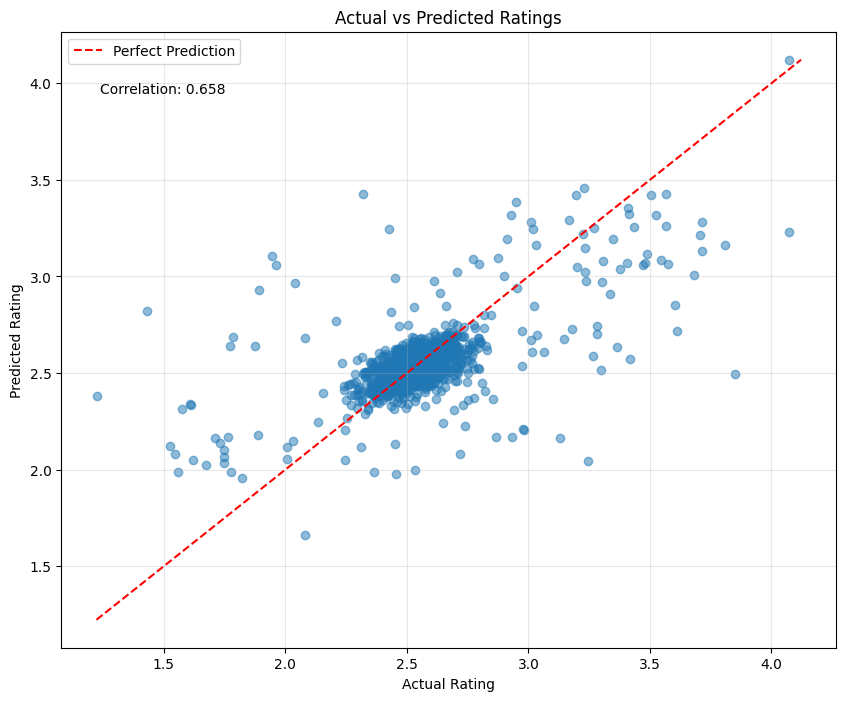


Results saved to 'recommendation_results.csv'


In [48]:
# Create visualization
plot_actual_vs_predicted(predictions)

# Save results
predictions.toPandas().to_csv("recommendation_results.csv", index=False)
print("\nResults saved to 'recommendation_results.csv'")

In [49]:
spark.stop()